## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2, 0.5, 0.8]
redice_lr_patient = [5, 10, 15]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizatio


Epoch 00047: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 48/50
50000/50000 [==============================] - 3s 55us/step - loss: 0.8632 - acc: 0.7166 - val_loss: 1.4467 - val_acc: 0.5055
Epoch 49/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.8623 - acc: 0.7150 - val_loss: 1.4467 - val_acc: 0.5056
Epoch 50/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.8625 - acc: 0.7166 - val_loss: 1.4467 - val_acc: 0.5059
Numbers of exp: 1, reduce_factor: 0.20, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)         

50000/50000 [==============================] - 3s 56us/step - loss: 2.4194 - acc: 0.2151 - val_loss: 2.3900 - val_acc: 0.2193
Epoch 46/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4126 - acc: 0.2163 - val_loss: 2.3842 - val_acc: 0.2202
Epoch 47/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4050 - acc: 0.2177 - val_loss: 2.3784 - val_acc: 0.2216
Epoch 48/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.3993 - acc: 0.2192 - val_loss: 2.3728 - val_acc: 0.2237
Epoch 49/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.3932 - acc: 0.2208 - val_loss: 2.3672 - val_acc: 0.2246
Epoch 50/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.3873 - acc: 0.2233 - val_loss: 2.3619 - val_acc: 0.2258
Numbers of exp: 2, reduce_factor: 0.20, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Para

50000/50000 [==============================] - 3s 56us/step - loss: 2.4249 - acc: 0.2152 - val_loss: 2.4403 - val_acc: 0.2154
Epoch 44/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4185 - acc: 0.2172 - val_loss: 2.4345 - val_acc: 0.2169
Epoch 45/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4126 - acc: 0.2188 - val_loss: 2.4289 - val_acc: 0.2177
Epoch 46/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4064 - acc: 0.2193 - val_loss: 2.4228 - val_acc: 0.2195
Epoch 47/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4014 - acc: 0.2213 - val_loss: 2.4174 - val_acc: 0.2199
Epoch 48/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.3953 - acc: 0.2222 - val_loss: 2.4120 - val_acc: 0.2209
Epoch 49/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.3895 - acc: 0.2230 - val_loss: 2.4063 - val_acc: 0.2229
Epoch 50/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 56us/step - loss: 2.3936 - acc: 0.2178 - val_loss: 2.3873 - val_acc: 0.2193
Epoch 42/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.3881 - acc: 0.2196 - val_loss: 2.3811 - val_acc: 0.2212
Epoch 43/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.3816 - acc: 0.2200 - val_loss: 2.3752 - val_acc: 0.2216
Epoch 44/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.3746 - acc: 0.2222 - val_loss: 2.3695 - val_acc: 0.2233
Epoch 45/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.3692 - acc: 0.2241 - val_loss: 2.3640 - val_acc: 0.2244
Epoch 46/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.3629 - acc: 0.2246 - val_loss: 2.3581 - val_acc: 0.2257
Epoch 47/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.3576 - acc: 0.2280 - val_loss: 2.3529 - val_acc: 0.2275
Epoch 48/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 56us/step - loss: 2.4116 - acc: 0.2159 - val_loss: 2.4132 - val_acc: 0.2150
Epoch 40/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4045 - acc: 0.2167 - val_loss: 2.4070 - val_acc: 0.2164
Epoch 41/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.3986 - acc: 0.2188 - val_loss: 2.4007 - val_acc: 0.2176
Epoch 42/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.3917 - acc: 0.2193 - val_loss: 2.3945 - val_acc: 0.2188
Epoch 43/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.3856 - acc: 0.2222 - val_loss: 2.3889 - val_acc: 0.2196
Epoch 44/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.3795 - acc: 0.2239 - val_loss: 2.3830 - val_acc: 0.2204
Epoch 45/50
50000/50000 [==============================] - 3s 55us/step - loss: 2.3729 - acc: 0.2247 - val_loss: 2.3773 - val_acc: 0.2218
Epoch 46/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 56us/step - loss: 2.4550 - acc: 0.2009 - val_loss: 2.4575 - val_acc: 0.2011
Epoch 38/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4479 - acc: 0.2018 - val_loss: 2.4505 - val_acc: 0.2032
Epoch 39/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4407 - acc: 0.2047 - val_loss: 2.4438 - val_acc: 0.2048
Epoch 40/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4346 - acc: 0.2065 - val_loss: 2.4372 - val_acc: 0.2066
Epoch 41/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4263 - acc: 0.2077 - val_loss: 2.4309 - val_acc: 0.2082
Epoch 42/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.4199 - acc: 0.2089 - val_loss: 2.4246 - val_acc: 0.2090
Epoch 43/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4130 - acc: 0.2107 - val_loss: 2.4184 - val_acc: 0.2104
Epoch 44/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 57us/step - loss: 2.4925 - acc: 0.1935 - val_loss: 2.4716 - val_acc: 0.1989
Epoch 36/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4854 - acc: 0.1945 - val_loss: 2.4636 - val_acc: 0.2016
Epoch 37/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.4777 - acc: 0.1974 - val_loss: 2.4558 - val_acc: 0.2027
Epoch 38/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.4682 - acc: 0.1985 - val_loss: 2.4480 - val_acc: 0.2038
Epoch 39/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.4616 - acc: 0.2008 - val_loss: 2.4407 - val_acc: 0.2055
Epoch 40/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4539 - acc: 0.2019 - val_loss: 2.4336 - val_acc: 0.2069
Epoch 41/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.4461 - acc: 0.2040 - val_loss: 2.4265 - val_acc: 0.2081
Epoch 42/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 58us/step - loss: 2.4781 - acc: 0.2022 - val_loss: 2.4543 - val_acc: 0.2079
Epoch 34/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.4701 - acc: 0.2035 - val_loss: 2.4467 - val_acc: 0.2098
Epoch 35/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.4627 - acc: 0.2056 - val_loss: 2.4397 - val_acc: 0.2103
Epoch 36/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4533 - acc: 0.2084 - val_loss: 2.4330 - val_acc: 0.2121
Epoch 37/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4460 - acc: 0.2092 - val_loss: 2.4261 - val_acc: 0.2132
Epoch 38/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.4386 - acc: 0.2105 - val_loss: 2.4196 - val_acc: 0.2135
Epoch 39/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.4323 - acc: 0.2115 - val_loss: 2.4134 - val_acc: 0.2150
Epoch 40/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 57us/step - loss: 2.5360 - acc: 0.1795 - val_loss: 2.5271 - val_acc: 0.1852
Epoch 32/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.5265 - acc: 0.1814 - val_loss: 2.5175 - val_acc: 0.1878
Epoch 33/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.5171 - acc: 0.1830 - val_loss: 2.5085 - val_acc: 0.1898
Epoch 34/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.5075 - acc: 0.1858 - val_loss: 2.4999 - val_acc: 0.1915
Epoch 35/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.4994 - acc: 0.1869 - val_loss: 2.4914 - val_acc: 0.1948
Epoch 36/50
50000/50000 [==============================] - 3s 56us/step - loss: 2.4903 - acc: 0.1891 - val_loss: 2.4831 - val_acc: 0.1966
Epoch 37/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.4819 - acc: 0.1905 - val_loss: 2.4752 - val_acc: 0.1980
Epoch 38/50
50000/50000 [=====================


Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 28/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.6247 - acc: 0.8046 - val_loss: 1.3559 - val_acc: 0.5387
Epoch 29/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.6234 - acc: 0.8043 - val_loss: 1.3565 - val_acc: 0.5382
Epoch 30/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.6245 - acc: 0.8037 - val_loss: 1.3568 - val_acc: 0.5391
Epoch 31/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.6243 - acc: 0.8042 - val_loss: 1.3569 - val_acc: 0.5385
Epoch 32/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.6234 - acc: 0.8052 - val_loss: 1.3573 - val_acc: 0.5378

Epoch 00032: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
Epoch 33/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.6237 - acc: 0.8052 - val_loss: 1.3575 - val_acc: 0.5379
Epoch 34/

50000/50000 [==============================] - 3s 60us/step - loss: 3.2165 - acc: 0.0800 - val_loss: 3.2045 - val_acc: 0.0822
Epoch 24/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.2156 - acc: 0.0794 - val_loss: 3.2039 - val_acc: 0.0821
Epoch 25/50
50000/50000 [==============================] - 3s 62us/step - loss: 3.2161 - acc: 0.0803 - val_loss: 3.2036 - val_acc: 0.0819
Epoch 26/50
50000/50000 [==============================] - 3s 62us/step - loss: 3.2154 - acc: 0.0801 - val_loss: 3.2032 - val_acc: 0.0821
Epoch 27/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.2143 - acc: 0.0804 - val_loss: 3.2028 - val_acc: 0.0820
Epoch 28/50
50000/50000 [==============================] - 3s 60us/step - loss: 3.2147 - acc: 0.0804 - val_loss: 3.2023 - val_acc: 0.0822
Epoch 29/50
50000/50000 [==============================] - 3s 60us/step - loss: 3.2134 - acc: 0.0803 - val_loss: 3.2020 - val_acc: 0.0821
Epoch 30/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 61us/step - loss: 3.1308 - acc: 0.0894 - val_loss: 3.1358 - val_acc: 0.0883
Epoch 22/50
50000/50000 [==============================] - 3s 62us/step - loss: 3.1311 - acc: 0.0898 - val_loss: 3.1355 - val_acc: 0.0884
Epoch 23/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.1302 - acc: 0.0885 - val_loss: 3.1352 - val_acc: 0.0884
Epoch 24/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.1305 - acc: 0.0888 - val_loss: 3.1350 - val_acc: 0.0885
Epoch 25/50
50000/50000 [==============================] - 3s 60us/step - loss: 3.1286 - acc: 0.0897 - val_loss: 3.1347 - val_acc: 0.0885
Epoch 26/50
50000/50000 [==============================] - 3s 60us/step - loss: 3.1289 - acc: 0.0885 - val_loss: 3.1346 - val_acc: 0.0884
Epoch 27/50
50000/50000 [==============================] - 3s 60us/step - loss: 3.1294 - acc: 0.0887 - val_loss: 3.1341 - val_acc: 0.0883
Epoch 28/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 61us/step - loss: 3.0722 - acc: 0.1016 - val_loss: 3.0624 - val_acc: 0.1014
Epoch 20/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.0717 - acc: 0.1013 - val_loss: 3.0621 - val_acc: 0.1013
Epoch 21/50
50000/50000 [==============================] - 3s 62us/step - loss: 3.0717 - acc: 0.1011 - val_loss: 3.0617 - val_acc: 0.1014
Epoch 22/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.0720 - acc: 0.1013 - val_loss: 3.0615 - val_acc: 0.1014
Epoch 23/50
50000/50000 [==============================] - 3s 63us/step - loss: 3.0704 - acc: 0.1013 - val_loss: 3.0613 - val_acc: 0.1014
Epoch 24/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.0698 - acc: 0.1013 - val_loss: 3.0610 - val_acc: 0.1015
Epoch 25/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.0694 - acc: 0.1013 - val_loss: 3.0606 - val_acc: 0.1016
Epoch 26/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 62us/step - loss: 3.0761 - acc: 0.0926 - val_loss: 3.0601 - val_acc: 0.0932
Epoch 18/50
50000/50000 [==============================] - 3s 62us/step - loss: 3.0759 - acc: 0.0917 - val_loss: 3.0600 - val_acc: 0.0932
Epoch 19/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.0753 - acc: 0.0919 - val_loss: 3.0595 - val_acc: 0.0932
Epoch 20/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.0750 - acc: 0.0939 - val_loss: 3.0591 - val_acc: 0.0932
Epoch 21/50
50000/50000 [==============================] - 3s 62us/step - loss: 3.0742 - acc: 0.0926 - val_loss: 3.0588 - val_acc: 0.0932
Epoch 22/50
50000/50000 [==============================] - 3s 62us/step - loss: 3.0740 - acc: 0.0927 - val_loss: 3.0581 - val_acc: 0.0933
Epoch 23/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.0725 - acc: 0.0923 - val_loss: 3.0579 - val_acc: 0.0933
Epoch 24/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 62us/step - loss: 3.0731 - acc: 0.0957 - val_loss: 3.0711 - val_acc: 0.0963
Epoch 16/50
50000/50000 [==============================] - 3s 63us/step - loss: 3.0725 - acc: 0.0966 - val_loss: 3.0711 - val_acc: 0.0963
Epoch 17/50
50000/50000 [==============================] - 3s 63us/step - loss: 3.0739 - acc: 0.0962 - val_loss: 3.0706 - val_acc: 0.0963
Epoch 18/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.0732 - acc: 0.0959 - val_loss: 3.0704 - val_acc: 0.0963
Epoch 19/50
50000/50000 [==============================] - 3s 62us/step - loss: 3.0722 - acc: 0.0965 - val_loss: 3.0703 - val_acc: 0.0962
Epoch 20/50
50000/50000 [==============================] - 3s 60us/step - loss: 3.0705 - acc: 0.0964 - val_loss: 3.0699 - val_acc: 0.0963
Epoch 21/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.0705 - acc: 0.0963 - val_loss: 3.0696 - val_acc: 0.0963
Epoch 22/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 61us/step - loss: 2.9721 - acc: 0.1105 - val_loss: 2.9640 - val_acc: 0.1095
Epoch 14/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.9698 - acc: 0.1109 - val_loss: 2.9636 - val_acc: 0.1097
Epoch 15/50
50000/50000 [==============================] - 3s 60us/step - loss: 2.9705 - acc: 0.1106 - val_loss: 2.9633 - val_acc: 0.1098
Epoch 16/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.9684 - acc: 0.1112 - val_loss: 2.9630 - val_acc: 0.1096
Epoch 17/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.9699 - acc: 0.1112 - val_loss: 2.9626 - val_acc: 0.1097
Epoch 18/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.9696 - acc: 0.1109 - val_loss: 2.9623 - val_acc: 0.1097
Epoch 19/50
50000/50000 [==============================] - 3s 60us/step - loss: 2.9698 - acc: 0.1107 - val_loss: 2.9620 - val_acc: 0.1098
Epoch 20/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 61us/step - loss: 2.8924 - acc: 0.1065 - val_loss: 2.8758 - val_acc: 0.1063
Epoch 12/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.8928 - acc: 0.1055 - val_loss: 2.8756 - val_acc: 0.1063
Epoch 13/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.8911 - acc: 0.1056 - val_loss: 2.8754 - val_acc: 0.1065
Epoch 14/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.8901 - acc: 0.1062 - val_loss: 2.8752 - val_acc: 0.1063
Epoch 15/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.8916 - acc: 0.1060 - val_loss: 2.8748 - val_acc: 0.1064
Epoch 16/50
50000/50000 [==============================] - 3s 60us/step - loss: 2.8903 - acc: 0.1056 - val_loss: 2.8745 - val_acc: 0.1066
Epoch 17/50
50000/50000 [==============================] - 3s 60us/step - loss: 2.8910 - acc: 0.1063 - val_loss: 2.8741 - val_acc: 0.1066
Epoch 18/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 61us/step - loss: 3.0831 - acc: 0.0981 - val_loss: 3.0870 - val_acc: 0.0942
Epoch 10/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.0824 - acc: 0.0977 - val_loss: 3.0865 - val_acc: 0.0941
Epoch 11/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.0833 - acc: 0.0982 - val_loss: 3.0860 - val_acc: 0.0940
Epoch 12/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.0823 - acc: 0.0972 - val_loss: 3.0858 - val_acc: 0.0942
Epoch 13/50
50000/50000 [==============================] - 3s 66us/step - loss: 3.0829 - acc: 0.0980 - val_loss: 3.0853 - val_acc: 0.0941
Epoch 14/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.0812 - acc: 0.0980 - val_loss: 3.0851 - val_acc: 0.0940
Epoch 15/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.0806 - acc: 0.0981 - val_loss: 3.0848 - val_acc: 0.0941
Epoch 16/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 60us/step - loss: 1.1781 - acc: 0.5835 - val_loss: 2.2593 - val_acc: 0.3190
Epoch 8/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.1362 - acc: 0.6005 - val_loss: 1.8119 - val_acc: 0.3931
Epoch 9/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.0969 - acc: 0.6138 - val_loss: 1.9086 - val_acc: 0.3637
Epoch 10/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.0549 - acc: 0.6288 - val_loss: 1.6048 - val_acc: 0.4435
Epoch 11/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.0141 - acc: 0.6434 - val_loss: 1.7011 - val_acc: 0.4195
Epoch 12/50
50000/50000 [==============================] - 3s 59us/step - loss: 0.9769 - acc: 0.6564 - val_loss: 1.7236 - val_acc: 0.4241
Epoch 13/50
50000/50000 [==============================] - 3s 59us/step - loss: 0.9469 - acc: 0.6668 - val_loss: 1.7491 - val_acc: 0.4302
Epoch 14/50
50000/50000 [=======================

50000/50000 [==============================] - 5s 107us/step - loss: 2.9789 - acc: 0.1091 - val_loss: 2.9885 - val_acc: 0.1043
Epoch 2/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.9764 - acc: 0.1095 - val_loss: 2.9865 - val_acc: 0.1040
Epoch 3/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.9772 - acc: 0.1092 - val_loss: 2.9851 - val_acc: 0.1045
Epoch 4/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.9746 - acc: 0.1098 - val_loss: 2.9836 - val_acc: 0.1047
Epoch 5/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.9728 - acc: 0.1100 - val_loss: 2.9823 - val_acc: 0.1049
Epoch 6/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.9714 - acc: 0.1090 - val_loss: 2.9809 - val_acc: 0.1050
Epoch 7/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.9703 - acc: 0.1093 - val_loss: 2.9796 - val_acc: 0.1052
Epoch 8/50
50000/50000 [===========================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 109us/step - loss: 3.1327 - acc: 0.0967 - val_loss: 3.1138 - val_acc: 0.1010
Epoch 2/50
50000/50000 [==============================] - 3s 60us/step - loss: 3.1293 - acc: 0.0967 - val_loss: 3.1123 - val_acc: 0.1010
Epoch 3/50
50000/50000 [==============================] - 3s 60us/step - loss: 3.1269 - acc: 0.0959 - val_loss: 3.1108 - val_acc: 0.1012
Epoch 4/50
50000/50000 [==============================] - 3s 60us/step - loss: 3.1260 - acc: 0.0968 - val_loss: 3.1088 - val_acc: 0.1016
Epoch 5/50
50000/50000 [==============================] - 3s 58us/step - loss: 3.1235 - acc: 0.0976 - val_loss: 3.1074 - val_acc: 0.1016
Epoch 6/50
50000/50000 [==============================] - 3s 58us/step - loss: 3.1231 - acc: 0.0973 - val_loss: 3.1061 - val_acc: 0.1017
Epoch 7/50
50000/50000 [==============================] - 3s 59us/step - loss: 3.1222 - acc: 0.0967 - val_loss: 3.1044 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 120us/step - loss: 3.1099 - acc: 0.0944 - val_loss: 3.1192 - val_acc: 0.0954
Epoch 2/50
50000/50000 [==============================] - 3s 58us/step - loss: 3.1092 - acc: 0.0951 - val_loss: 3.1177 - val_acc: 0.0956
Epoch 3/50
50000/50000 [==============================] - 3s 59us/step - loss: 3.1065 - acc: 0.0954 - val_loss: 3.1162 - val_acc: 0.0958
Epoch 4/50
50000/50000 [==============================] - 3s 59us/step - loss: 3.1055 - acc: 0.0946 - val_loss: 3.1146 - val_acc: 0.0959
Epoch 5/50
50000/50000 [==============================] - 3s 61us/step - loss: 3.1044 - acc: 0.0951 - val_loss: 3.1132 - val_acc: 0.0958
Epoch 6/50
50000/50000 [==============================] - 3s 57us/step - loss: 3.1033 - acc: 0.0962 - val_loss: 3.1119 - val_acc: 0.0960
Epoch 7/50
50000/50000 [==============================] - 3s 59us/step - loss: 3.1015 - acc: 0.0943 - val_loss: 3.1106 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 114us/step - loss: 3.1540 - acc: 0.0888 - val_loss: 3.1822 - val_acc: 0.0884
Epoch 2/50
50000/50000 [==============================] - 3s 58us/step - loss: 3.1519 - acc: 0.0897 - val_loss: 3.1809 - val_acc: 0.0885
Epoch 3/50
50000/50000 [==============================] - 3s 58us/step - loss: 3.1508 - acc: 0.0899 - val_loss: 3.1795 - val_acc: 0.0885
Epoch 4/50
50000/50000 [==============================] - 3s 58us/step - loss: 3.1488 - acc: 0.0892 - val_loss: 3.1780 - val_acc: 0.0886
Epoch 5/50
50000/50000 [==============================] - 3s 57us/step - loss: 3.1467 - acc: 0.0896 - val_loss: 3.1763 - val_acc: 0.0886
Epoch 6/50
50000/50000 [==============================] - 3s 57us/step - loss: 3.1465 - acc: 0.0895 - val_loss: 3.1748 - val_acc: 0.0889
Epoch 7/50
50000/50000 [==============================] - 3s 58us/step - loss: 3.1440 - acc: 0.0902 - val_loss: 3.1732 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 121us/step - loss: 2.9299 - acc: 0.1225 - val_loss: 2.9020 - val_acc: 0.1290
Epoch 2/50
50000/50000 [==============================] - 3s 60us/step - loss: 2.9285 - acc: 0.1235 - val_loss: 2.9006 - val_acc: 0.1292
Epoch 3/50
50000/50000 [==============================] - 3s 60us/step - loss: 2.9270 - acc: 0.1242 - val_loss: 2.8993 - val_acc: 0.1295
Epoch 4/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.9256 - acc: 0.1234 - val_loss: 2.8980 - val_acc: 0.1297
Epoch 5/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.9248 - acc: 0.1235 - val_loss: 2.8967 - val_acc: 0.1299
Epoch 6/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.9237 - acc: 0.1232 - val_loss: 2.8956 - val_acc: 0.1302
Epoch 7/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.9230 - acc: 0.1244 - val_loss: 2.8945 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 114us/step - loss: 3.0637 - acc: 0.0941 - val_loss: 3.0414 - val_acc: 0.0942
Epoch 2/50
50000/50000 [==============================] - 3s 57us/step - loss: 3.0633 - acc: 0.0948 - val_loss: 3.0395 - val_acc: 0.0943
Epoch 3/50
50000/50000 [==============================] - 3s 57us/step - loss: 3.0621 - acc: 0.0940 - val_loss: 3.0378 - val_acc: 0.0942
Epoch 4/50
50000/50000 [==============================] - 3s 57us/step - loss: 3.0591 - acc: 0.0949 - val_loss: 3.0363 - val_acc: 0.0944
Epoch 5/50
50000/50000 [==============================] - 3s 57us/step - loss: 3.0581 - acc: 0.0944 - val_loss: 3.0351 - val_acc: 0.0946
Epoch 6/50
50000/50000 [==============================] - 3s 57us/step - loss: 3.0577 - acc: 0.0937 - val_loss: 3.0339 - val_acc: 0.0948
Epoch 7/50
50000/50000 [==============================] - 3s 57us/step - loss: 3.0566 - acc: 0.0948 - val_loss: 3.0325 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 127us/step - loss: 3.1454 - acc: 0.0980 - val_loss: 3.1356 - val_acc: 0.1005
Epoch 2/50
50000/50000 [==============================] - 3s 59us/step - loss: 3.1422 - acc: 0.0977 - val_loss: 3.1339 - val_acc: 0.1007
Epoch 3/50
50000/50000 [==============================] - 3s 58us/step - loss: 3.1425 - acc: 0.0983 - val_loss: 3.1323 - val_acc: 0.1005
Epoch 4/50
50000/50000 [==============================] - 3s 58us/step - loss: 3.1391 - acc: 0.0991 - val_loss: 3.1307 - val_acc: 0.1009
Epoch 5/50
50000/50000 [==============================] - 3s 58us/step - loss: 3.1390 - acc: 0.0979 - val_loss: 3.1292 - val_acc: 0.1015
Epoch 6/50
50000/50000 [==============================] - 3s 58us/step - loss: 3.1384 - acc: 0.0993 - val_loss: 3.1275 - val_acc: 0.1014
Epoch 7/50
50000/50000 [==============================] - 3s 59us/step - loss: 3.1366 - acc: 0.0986 - val_loss: 3.1261 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 118us/step - loss: 3.0398 - acc: 0.1012 - val_loss: 3.0445 - val_acc: 0.1012
Epoch 2/50
50000/50000 [==============================] - 3s 57us/step - loss: 3.0408 - acc: 0.1010 - val_loss: 3.0427 - val_acc: 0.1013
Epoch 3/50
50000/50000 [==============================] - 3s 57us/step - loss: 3.0387 - acc: 0.1020 - val_loss: 3.0412 - val_acc: 0.1014
Epoch 4/50
50000/50000 [==============================] - 3s 57us/step - loss: 3.0370 - acc: 0.1017 - val_loss: 3.0395 - val_acc: 0.1020
Epoch 5/50
50000/50000 [==============================] - 3s 57us/step - loss: 3.0360 - acc: 0.1018 - val_loss: 3.0382 - val_acc: 0.1021
Epoch 6/50
50000/50000 [==============================] - 3s 58us/step - loss: 3.0335 - acc: 0.1022 - val_loss: 3.0368 - val_acc: 0.1020
Epoch 7/50
50000/50000 [==============================] - 3s 57us/step - loss: 3.0320 - acc: 0.1026 - val_loss: 3.0353 - val_ac

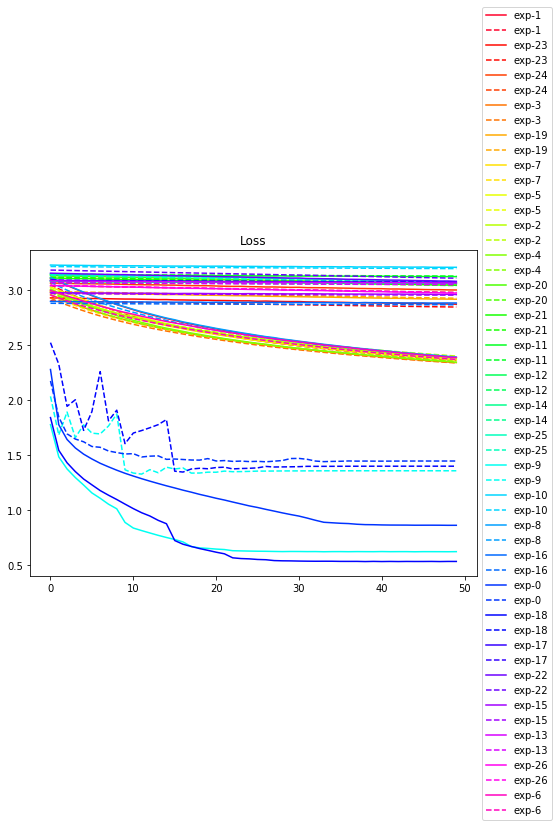

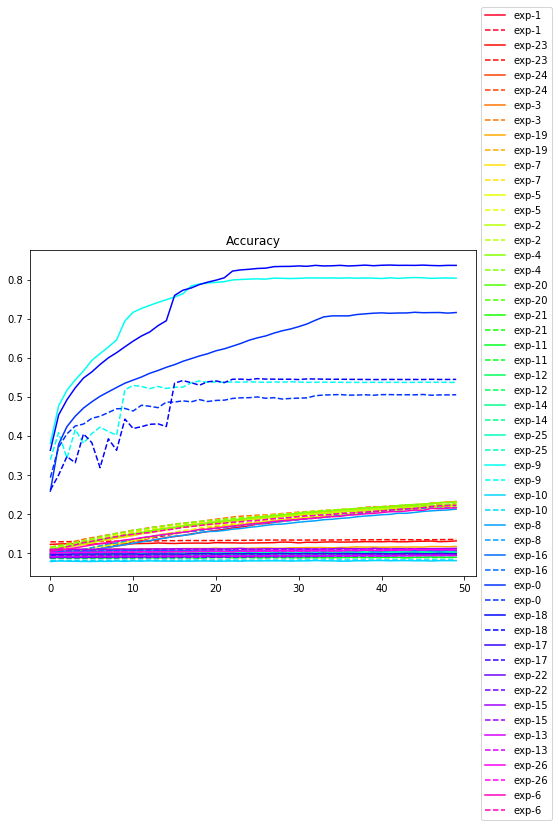

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()